In [50]:
import numpy as np
import sys  
import matplotlib.pyplot as plt
import pickle
import gymnasium
import mountain_lite
fd = open('trajectories.pickle','rb')
D = pickle.load(fd)



In [51]:
env = gymnasium.make('mountain_lite/GridWorld-v0')

# task 1:


In [3]:
def mc_prediction_v(D, gamma=0.9):
    """
    Estimate the state-value function v_pi(s) using Monte Carlo evaluation.

    Parameters:
    - D: Trajectories, a list of episodes
    - gamma: Discount factor

    Returns:
    - V: The estimated state-value function
    """
    V = np.zeros((31, 100))  # Initialize state-value function
    returns = {}  # Dictionary to store returns for each state

    # Initialize returns
    for i in range(31):
        for j in range(100):
            returns[(i, j)] = []

    # Loop over trajectories
    for trajectory in D:
        G = 0  # Initialize return
        for step in reversed(trajectory):
            state, _, reward, _ = step
            G = reward + gamma * G
            if state not in [x[0] for x in trajectory[:trajectory.index(step)]]:
                returns[state].append(G)

    # Calculate average return for each state
    for state, Gs in returns.items():
        if Gs:  # Avoid division by zero
            V[state] = np.mean(Gs)

    return V


In [4]:
V = mc_prediction_v(D)

# task 2:

In [108]:
def mc_prediction_q(D, gamma=0.9):
    """
    Estimate the action-value function q_pi(a, s) using Monte Carlo evaluation.

    Parameters:
    - D: Trajectories, a list of episodes
    - gamma: Discount factor

    Returns:
    - Q: The estimated action-value function
    """
    Q = np.zeros((31, 100, 8))  # Initialize action-value function
    returns = {}  # Dictionary to store returns for each state-action pair

    # Initialize returns
    for i in range(31):
        for j in range(100):
            for a in range(8):
                returns[(i, j, a)] = []
    
    # Loop over trajectories
    for trajectory in D:
        print(trajectory)
        G = 0  # Initialize return
        for step in reversed(trajectory):
            state, action, reward, _ = step
            G = reward + gamma * G
            print(step)
            print(state, action, reward, G)
            print(len(trajectory),len(trajectory[0]))
            print(trajectory.index(step))
            if (state, action) not in [(x[0], x[1]) for x in trajectory[:trajectory.index(step)]]:
                returns[(state + (action,))].append(G)

    # Calculate average return for each state-action pair
    for state_action, Gs in returns.items():
        if Gs:  # Avoid division by zero
            Q[state_action] = np.mean(Gs)

    return Q


In [109]:
Q = mc_prediction_q(D)

[((15, 0), 0, -0.5058824, (14, 0)), ((14, 0), 6, -0.5058824, (14, 0)), ((14, 0), 5, -0.5058824, (15, 1)), ((15, 1), 3, -0.5058824, (16, 0)), ((16, 0), 3, -0.5058824, (17, 0)), ((17, 0), 6, -0.5058824, (17, 0)), ((17, 0), 0, -0.5058824, (16, 0)), ((16, 0), 5, -0.5058824, (17, 0)), ((17, 0), 1, -0.5058824, (16, 0)), ((16, 0), 0, -0.5058824, (15, 0)), ((15, 0), 4, -0.5058824, (16, 0)), ((16, 0), 7, -0.5058824, (16, 1)), ((16, 1), 5, -0.5058824, (17, 2)), ((17, 2), 6, -0.5058824, (17, 1)), ((17, 1), 5, -0.5058824, (18, 2)), ((18, 2), 6, -0.57254905, (18, 1)), ((18, 1), 4, -0.5058824, (19, 1)), ((19, 1), 1, -0.5058824, (18, 0)), ((18, 0), 6, -0.5058824, (18, 0)), ((18, 0), 3, -0.5058824, (19, 0)), ((19, 0), 4, -0.5058824, (20, 0)), ((20, 0), 2, -0.5058824, (19, 1)), ((19, 1), 1, -0.5058824, (18, 0)), ((18, 0), 7, -0.5058824, (18, 1)), ((18, 1), 6, -0.5058824, (18, 0)), ((18, 0), 5, -0.5058824, (18, 1)), ((18, 1), 3, -0.5058824, (19, 0)), ((19, 0), 6, -0.5058824, (19, 0)), ((19, 0), 4, -0.50

KeyboardInterrupt: 

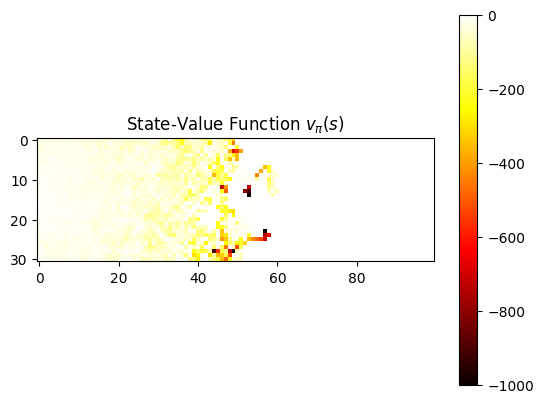

In [7]:
def plot_v(V):
    """
    Plot the state-value function v_pi(s).

    Parameters:
    - V: State-value function

    """
    plt.imshow(V, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('State-Value Function $v_π(s)$')
    plt.show()
plot_v(V)

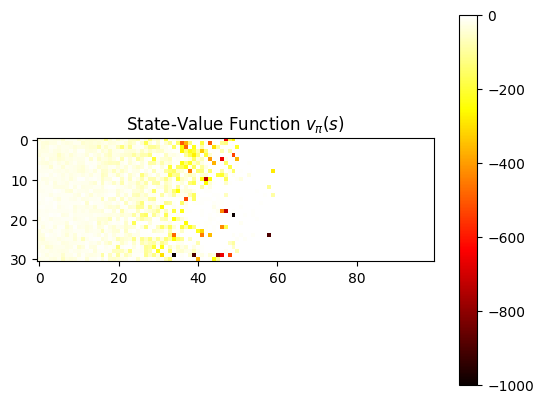

In [8]:
plot_v(Q[:,:,0])

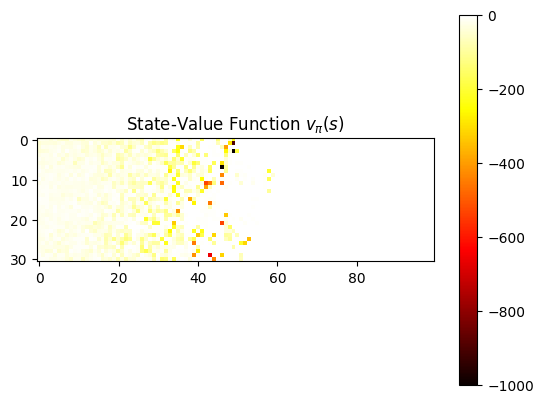

In [9]:
plot_v(Q[:,:,1])

# Task 5:

In [10]:
def mc_improvement(Q, epsilon=0.1):
    """
    Derive an improved policy from the action-value function Q using an epsilon-greedy approach.

    Parameters:
    - Q: The estimated action-value function, a numpy array of shape (num_states, num_actions)
    - epsilon: The probability of choosing a random action (exploration). 1 - epsilon is the probability of choosing the current best action (exploitation).

    Returns:
    - policy: The improved policy, a numpy array of shape (num_states,) indicating the best action for each state
    """
    policy = np.zeros((31, 100), dtype=int)  # Initialize policy with zeros

    for i in range(31):  # Loop over all states
        for j in range(100):
            if np.random.rand() < epsilon:  # With probability epsilon, choose a random action
                policy[i, j] = np.random.choice(8)
            else:  # With probability 1 - epsilon, choose the best action based on Q
                best_action = np.argmax(Q[i, j, :])
                policy[i, j] = best_action

    return policy


# technically task 5 and 6:

In [16]:
# MC Prediction Function for a single trajectory
def mc_prediction_q(trajectory, policy, gamma=0.9):
    Q = {}
    returns = {}

    G = 0
    for step in reversed(trajectory):
        state, action, reward, _ = step
        G = gamma * G + reward
        # Check if we have not visited this state-action pair in this trajectory
        if not step in trajectory[:trajectory.index(step)]:
            if (state, action) not in returns:
                returns[(state, action)] = []
            returns[(state, action)].append(G)
            Q[(state, action)] = np.mean(returns[(state, action)])
    return Q

# MC Improvement Function
def mc_improvement(Q, state_space, epsilon=0.1):
    policy = {}
    for state in state_space:
        actions = {a: Q.get((state, a), float('-inf')) for a in range(8)}
        best_action = max(actions, key=actions.get)
        if np.random.rand() < epsilon:
            policy[state] = np.random.choice(range(8))
        else:
            policy[state] = best_action
    return policy

# MC Control Function
def mc_control(D, num_iterations=10, gamma=0.9, epsilon=0.1):
    # Initialize policy randomly for states encountered in D
    state_space = set([step[0] for trajectory in D for step in trajectory])
    policy = {state: np.random.choice(range(8)) for state in state_space}
    
    for i in range(num_iterations):
        print('i',i)
        Q = {}
        # Loop through each trajectory in D
        # for trajectory in D:
        #     # Update the Q-values based on the trajectory and current policy
        #     Q.update(mc_prediction_q(trajectory, policy, gamma))
        for j in range(len(D)):
            
            Q.update(mc_prediction_q(D[j], policy, gamma))
            
            # Improve the policy based on the new action-value function estimate
            policy = mc_improvement(Q, state_space, epsilon)
        
    return policy

# Assuming D is defined as your dataset of trajectories
# optimal_policy = mc_control(D)


task 7-9

In [162]:

# Initialize Q-values
Q = np.zeros((31, 100, 8))  # For 31 rows, 100 columns, and 8 actions
returns = {(i, j, a): [] for i in range(31) for j in range(100) for a in range(8)}

# Initialize policy randomly
policy = np.random.choice(8, size=(31, 100))  # Each element is an action from 0 to 7

epsilon = 0.1  # Exploration rate
gamma = 0.9  # Discount factor




In [163]:
def generate_episode(env, policy, epsilon):
    episode = []
    state = env.reset()[0]['agent']['pos']
    # env._agent_location = np.array([10,10])
    # print(env.step(0))
    state = tuple(state)
    for i in range(500):    # account for battery life
        if np.random.rand() < epsilon:
            action = np.random.choice(8)  # Explore: choose a random action
        else:
            action = policy[state]  # Exploit: choose the best action from policy

        next_state, reward, _, _ ,_= env.step(action)
        next_state = next_state['agent']['pos']

        # print(next_state)
        episode.append((state, action, reward))
        # print("episode",episode)
        state = tuple(next_state)
    return episode

def update_Q(episode):
    G = 0
    for state, action, reward in reversed(episode):
        G = gamma * G + reward
        state_array = np.array(state)
        # print("Current state-action pair:", state, action)
        for s, a, _ in episode[:-1]:
            # print("Comparing with:", s, a)
            if np.array_equal(s, state_array) and a == action:
                # print("Match found!")
                break
        else:
            # print("No match found!")
            returns[state + (action,)].append(G)
            Q[state + (action,)] = np.mean(returns[state + (action,)])

def mc_prediction_q_tau(tau, gamma=0.9):
    """
    Estimate the action-value function q_pi(a, s) using Monte Carlo evaluation.

    Parameters:
    - D: Trajectories, a list of episodes
    - gamma: Discount factor

    Returns:
    - Q: The estimated action-value function
    """
    # Q = np.zeros((31, 100, 8))  # Initialize action-value function
    returns = {}  # Dictionary to store returns for each state-action pair

    # Initialize returns
    for i in range(31):
        for j in range(100):
            for a in range(8):
                returns[(i, j, a)] = []
    
    G = 0  # Initialize return
    for step in reversed(tau):
        state, action, reward= step
        G = reward + gamma * G
        state=tuple(state)
        if np.any((state, action) not in [(x[0], x[1]) for x in tau[:tau.index(step)]]):
            # print('here')
            returns[(state + (action,))].append(G)

    # Calculate average return for each state-action pair
    for state_action, Gs in returns.items():
        if Gs:  # Avoid division by zero
            # print('also here')
            Q[state_action] = np.mean(Gs)

    # return Q





In [164]:
def improve_policy():
    for i in range(31):
        for j in range(100):
            policy[i, j] = np.argmax(Q[i, j])
            

In [165]:
def control():
    num_episodes = 1000  # Total number of episodes to run
    for i in range(num_episodes):
        print(i)
        episode = generate_episode(env, policy, epsilon)
        # print('episode',episode)
        mc_prediction_q_tau(episode)
        # print('Q',Q)
        improve_policy()
        # print('policy',policy)


In [166]:
control() 
# policy[15,0]  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


KeyboardInterrupt: 

In [167]:
print(Q)
print(policy)

[[[-8.24030509 -8.17137073 -8.22976011 ... -8.24443124 -8.23894668
   -8.25163547]
  [-8.19664206 -7.96593289 -8.26746794 ... -8.23732519 -8.21956661
   -8.26498269]
  [-8.26678496 -8.19112345 -8.27189984 ... -7.77914233 -8.26919279
   -8.2744103 ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-8.24029111 -8.2262512  -8.21770268 ...  0.          0.
    0.        ]
  [-8.23069256 -8.25537044 -8.17437493 ...  0.          0.
    0.        ]
  [-8.24255092 -8.25763331 -8.06908519 ... -7.78405155 -7.72410148
   -7.33881802]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-8.00362218 -8.20835257 -8.16085904 ...  0.      

task 10-15

In [59]:
def epsilon_greedy_policy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q[state]))
    else:
        return np.argmax(Q[state])

def sarsa(env, episodes, alpha, gamma, epsilon):
    Q = np.zeros((31, 100, 8))  # Initialize Q-values for all state-action pairs
    
    for episode in range(episodes):
        state = env.reset()  # Start a new episode and get the initial state
        action = epsilon_greedy_policy(Q, state, epsilon)
        
        done = False
        while not done:
            next_state, reward, done, _ = env.step(action)  # Take action
            next_action = epsilon_greedy_policy(Q, next_state, epsilon)  # Choose next action
            
            # SARSA update rule
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            
            state, action = next_state, next_action  # Move to the next state and action
    
    # Derive policy from Q-values
    policy = np.argmax(Q, axis=2)
    return Q, policy

# Parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate
episodes = 10000  # Number of episodes


Q, policy = sarsa(env, episodes, alpha, gamma, epsilon)


6